# Predicting survival from passenger info

This is my first attempt at applying statistical methods to achieve predictive outcomes, which is pretty exciting.

However I recognise that for many readers, this will not be quite so exciting.

Like many others, I went through the [kaggle learning resources](https://www.kaggle.com/alexisbcook/titanic-tutorial) prior to my first submission, resulting in a reasonably high benchmark for the predictive accuracy coming from application of a simple random forest method.

For reference, before starting, this tutorial demonstrates the heavy bias for female survivorship. A prediction solely based on gender ('all females survived, all males did not') gives a test validation rate of 0.76555. Any improvement must begin from here.

In [1]:
from sklearn.ensemble import RandomForestClassifier

Simply by using the suggested features, there is a training data accuracy of **X**, resulting in a test set accuracy of 0.77511.

Looking into the scores for the challenge for the past few months, to get into the top 10% of submissions, you'd need roughly an 80.6% public accuracy against this test set. An increase of just over 3% from this point.

In [2]:
features = ["Pclass", "Sex", "SibSp", "Parch"]

model = RandomForestClassifier(n_estimators = 100, 
                               max_depth = 5, 
                               random_state = 1)

Having glanced over the data, I wanted to find out some basic features of the data. 
- How clean is this data? 
- What values are within each column? 
- Which values are missing, and how many? 

I started with looking at how many rows had missing values for each column, and then what each of the unique values were for each. 

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
print("train_data")
print(train_data.isnull().sum(axis = 0))
print("test_data")
print(test_data.isnull().sum(axis = 0))
for column in train_data.columns[1:]:
    print(column, 'column')
    print("Potential values:", train_data[column].unique())
    print("Number of missing values:", train_data[column].isna().sum())

train_data
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
test_data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
Survived column
Potential values: [0 1]
Number of missing values: 0
Pclass column
Potential values: [3 1 2]
Number of missing values: 0
Name column
Potential values: ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Ache

I then had a go at plotting the distributions for each of the columns to see the distribution of the existing values.

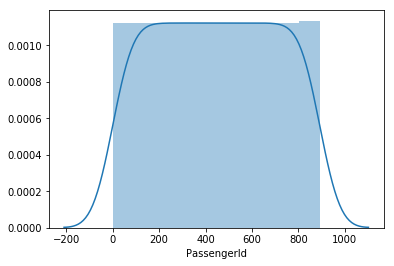

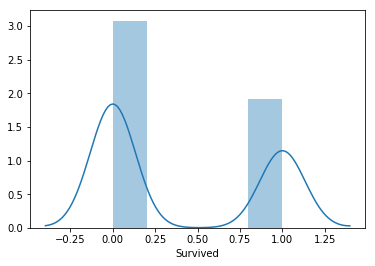

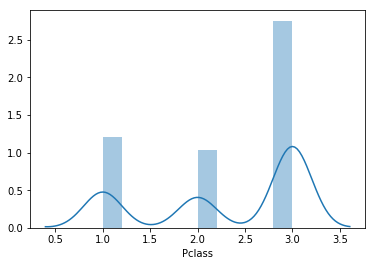

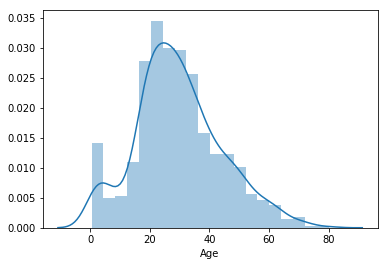

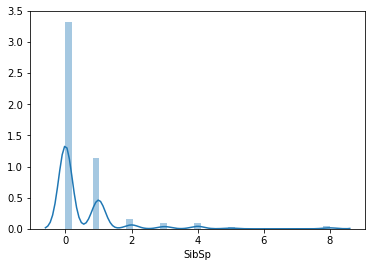

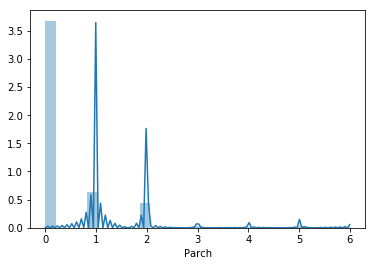

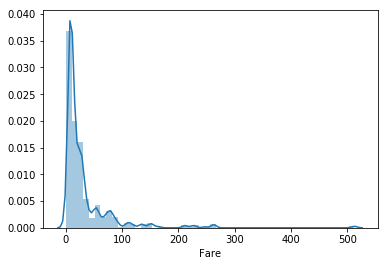

In [18]:
train_numeric = train_data.select_dtypes(include=np.number)
for i, col in enumerate(train_numeric.columns):
    col_data = train_numeric[col]
    col_anan_data = col_data[~np.isnan(col_data)]
    plt.figure(i)
    sns.distplot(col_anan_data)

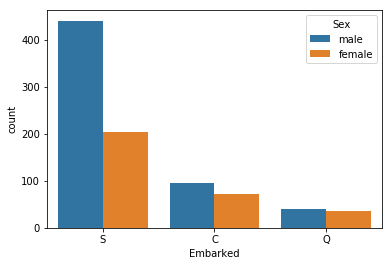

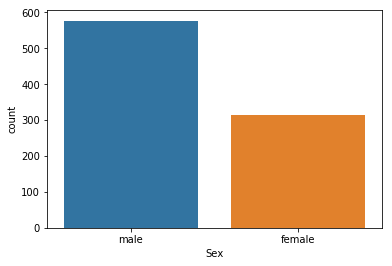

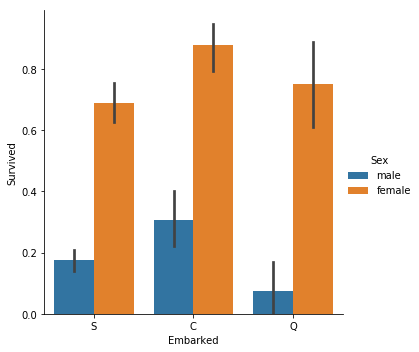

In [68]:
sns.countplot(data = train_data,
              x = "Embarked", 
              hue = "Sex")
plt.show()
sns.countplot(data = train_data,
              x = "Sex")

sns.catplot(data = train_data,
            x = "Embarked", 
            y = "Survived", 
            hue = "Sex", 
            kind = "bar")

Text(0.5, 1.0, 'Female passengers, Class and Embarkation location vs. survival')

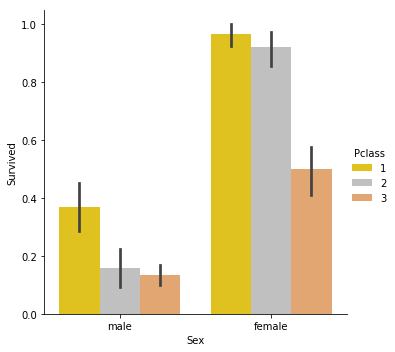

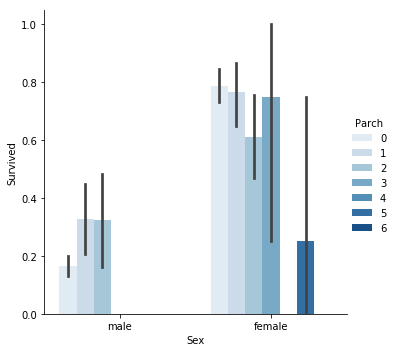

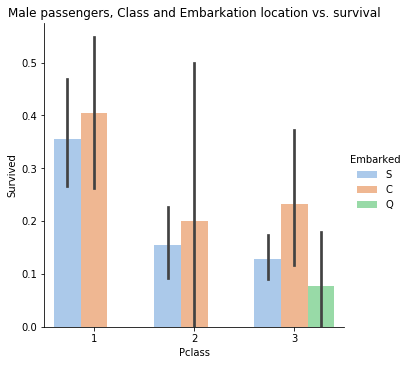

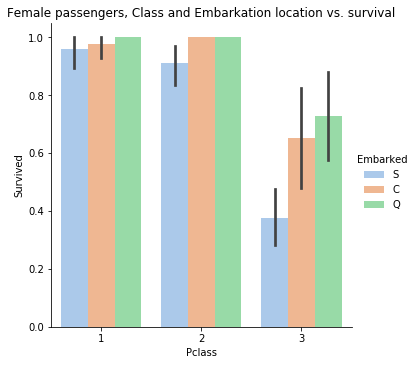

In [69]:
sns.catplot(data = train_data,
            x = "Sex", 
            y = "Survived", 
            hue = "Pclass", 
            kind = "bar",
            palette = ['gold', 'silver', 'sandybrown'])
sns.catplot(data = train_data,
            x = "Sex", 
            y = "Survived", 
            hue = "Parch", 
            kind = "bar",
            palette = sns.color_palette("Blues", 7))
sns.catplot(data = train_data[train_data['Sex'] == 'male'],
            x = "Pclass", 
            y = "Survived", 
            hue = "Embarked", 
            hue_order = ['S', 'C', 'Q'],
            kind = "bar",
            palette = 'pastel')
plt.title('Male passengers, Class and Embarkation location vs. survival')
sns.catplot(data = train_data[train_data['Sex'] == 'female'],
            x = "Pclass", 
            y = "Survived", 
            hue = "Embarked",
            hue_order = ['S', 'C', 'Q'],
            kind = "bar",
            palette = 'pastel')
plt.title('Female passengers, Class and Embarkation location vs. survival')

Text(0.5, 1.0, 'Embarkment location vs Age of male/female passengers from class')

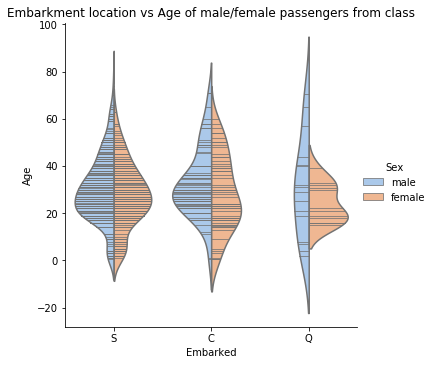

In [64]:
sns.catplot(data = train_data,
            x = "Embarked", 
            y = "Age", 
            hue = "Sex",
            hue_order = ['male', 'female'],
            kind="violin", 
            inner="stick", 
            split=True,
            palette="pastel")
plt.title('Embarkment location vs Age of male/female passengers from class')

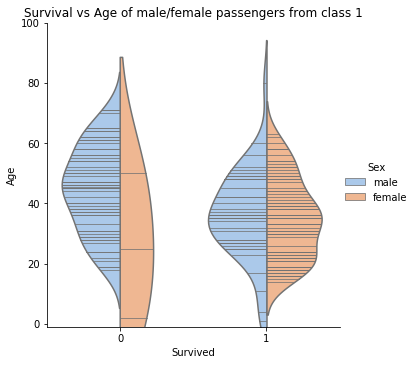

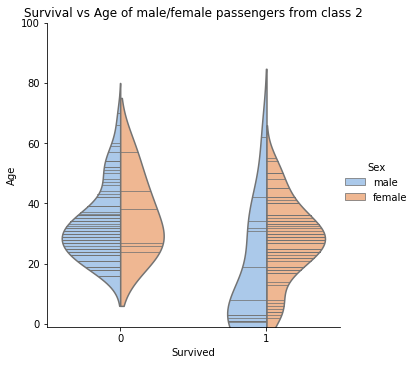

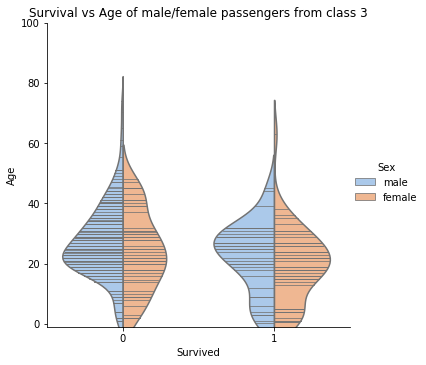

In [71]:
for i in range(1,4):
    data = train_data[train_data['Pclass'] == i]
    sns.catplot(data = data,
                x = "Survived", 
                y = "Age", 
                hue = "Sex",
                hue_order = ['male', 'female'],
                kind="violin", 
                inner="stick", 
                split=True,
                palette="pastel")
    plt.ylim(-1,100)
    plt.title('Survival vs Age of male/female passengers from class {}'.format(i))

A few notes at this point

Wow. First and second class women were almost guaranteed to survive (less likely if they had embarked from Southampton?!).

No such guarantees for the men - though being from first class appears to give a boost to your survival fitness on this particular boat.

Age as a predictor for survival:
- Looks like this is nuanced.
- Not working with a complete dataset 
    - roughly 1/3rd values missing at the moment
    - possible ways to infer age (see below)
- Not a predictor in 1st class
    - for women: almost all survive anyway
    - for men: no difference between surviving/perishing age distributions
- Looks like a good predictor for men in 2nd class
    - for women: again, most are surviving, likely no predictive use at the moment
    - for men: infants tend to survive (though this is a small sample size)
- 3rd class: age-ist
    - for both: very few survivors above the age of 35/40 (prominant in males)

- Embarkation points ([from wikipedia](https://en.wikipedia.org/wiki/RMS_Titanic):
    - S = Southampton
    - Q = Queenstown
    - C = Cherbourg

Tweaking the model parameters for the RandomForestClassifier number of estimators takes the accuracy up to 0.77990. A *slight* improvement. Looks like this model is relatively robust to changes here as this number is quite consistent.